In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier


import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)


pd.pandas.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.4f' % x)

In [2]:
# Lets conbine train and test datasets.
train = pd.read_csv("../input/house-price-dataset/test.csv")
test = pd.read_csv("../input/house-price-dataset/train.csv")
df = train.append(test).reset_index()
df.head()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1461,20,RH,80.0000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0000,TA,TA,CBlock,TA,TA,No,Rec,468.0000,LwQ,144.0000,270.0000,882.0000,GasA,TA,Y,SBrkr,896,0,0,896,0.0000,0.0000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0000,Unf,1.0000,730.0000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,nan
1,1,1462,20,RL,81.0000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0000,TA,TA,CBlock,TA,TA,No,ALQ,923.0000,Unf,0.0000,406.0000,1329.0000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0000,0.0000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0000,Unf,1.0000,312.0000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,nan
2,2,1463,60,RL,74.0000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0000,TA,TA,PConc,Gd,TA,No,GLQ,791.0000,Unf,0.0000,137.0000,928.0000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0000,0.0000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0000,Fin,2.0000,482.0000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,nan
3,3,1464,60,RL,78.0000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0000,TA,TA,PConc,TA,TA,No,GLQ,602.0000,Unf,0.0000,324.0000,926.0000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0000,0.0000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0000,Fin,2.0000,470.0000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,nan
4,4,1465,120,RL,43.0000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0000,Gd,TA,PConc,Gd,TA,No,ALQ,263.0000,Unf,0.0000,1017.0000,1280.0000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0000,0.0000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0000,RFn,2.0000,506.0000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,nan


In [3]:
def check_dataframe(dataframe):
    """
    -> provides an overview of the data

    :param dataframe:  dataframe to overview

    """

    print("Data Frame Raws Lenght : ", dataframe.shape[0],
          "\nData Frame Columns Lenght : ", dataframe.shape[1])

    print("\nData Frame Columns Names : ", list(dataframe.columns))

    print("\nIs data frame has null value? : ", dataframe.isnull().any())

    print("\nHow many missing values are in which columns? :\n", dataframe.isnull().sum())

    cat_names = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_names = [col for col in dataframe.columns if dataframe[col].dtype != "O"]

    print("\nHow many columns are in the object type? : ", len(cat_names), "\n", cat_names)

    print("\nHow many columns are in the numerical type? : ", len(num_names), "\n", num_names)

In [4]:
def get_categorical_and_numeric_columns(dataframe, exit_columns, number_of_unique_classes=25):
    """
    -> Determines categorical and numerical variables

    :param dataframe: dataframe to process
    :param exit_columns: Ignoring variable name
    :param number_of_unique_classes: Frequency limit of classes of variables
    :return: Returns the name of categorical classes as the first value and the name of numeric variables as the second value.

    """

    categorical_columns = [col for col in dataframe.columns
                           if len(dataframe[col].unique()) <= number_of_unique_classes]

    numeric_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) > number_of_unique_classes
                       and dataframe[col].dtype != "O"
                       and col not in exit_columns]

    return categorical_columns, numeric_columns

In [5]:
def cat_summary(dataframe, categorical_columns, target, plot=False):
    """
    -> Shows the proportion of classes of categorical variables and the median at target.

    :param dataframe: dataframe to process
    :param categorical_columns: name of categorical variables
    :param target: Dataframe'de ilgilendiğimiz değişken.
    :param plot: Argument for plotting graphics : True/False

    """
    for col in categorical_columns:
        print(col, " : ", dataframe[col].nunique(), " unique classes.\n")

        print(col, " : ", dataframe[col].value_counts().sum(), "\n")

        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO ( % )": 100 * dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEDIAN": dataframe.groupby(col)[target].median()}), end="\n\n\n")

        if plot:
            sns.countplot(x=col, data=dataframe)

            plt.show()

In [6]:
def hist_for_numeric_columns(dataframe, numeric_columns):
    """
    -> Plots histograms of numerical variables.

    :param dataframe: dataframe to process.
    :param numeric_columns: name of numerical variables

    """
    col_counter = 0

    data = dataframe.copy()

    for col in numeric_columns:
        data[col].hist(bins=20)

        plt.xlabel(col)

        plt.title(col)

        plt.show()

        col_counter += 1

    print(col_counter, "variables have been plotted!")

In [7]:
def find_correlation(dataframe, numeric_columns, target, corr_limit=0.60):
    """
    -> Examines the correlation of numeric variables with the target.

    :param dataframe: dataframe to process
    :param numeric_columns: name of numerical variables
    :param target: Target variable to look at in the correlation relation
    :param corr_limit: correlation limit. if it is below the limit is low correlation and above the boundary is high correlation.
    :return: First value is variables with low correlation, second value is variables with high correlation
    """
    high_correlations = []

    low_correlations = []

    for col in numeric_columns:
        if col == target:
            pass

        else:
            correlation = dataframe[[col, target]].corr().loc[col, target]

            if abs(correlation) > corr_limit:
                high_correlations.append(col + " : " + str(correlation))

            else:
                low_correlations.append(col + " : " + str(correlation))

    return low_correlations, high_correlations

In [8]:
def target_summary_with_categorical_columns(dataframe, categorical_columns, target):
    """
    -> Performs target analysis according to categorical variables.

    :param dataframe: dataframe to process
    :param categorical_columns: name of categorical variables 
    :param target: Name of the target variable to be analyzed
    :return:
    """
    for col in categorical_columns:
        if col != target:
            print(pd.DataFrame({"Target_Median": dataframe.groupby(col)[target].median()}), end="\n\n\n")

In [9]:

def target_summary_with_numeric_columns(dataframe, numeric_columns, exit_columns, target):
    """
    -> Target analysis according to numerical variables

    :param dataframe: dataframe to process
    :param numeric_columns: name of numerical variables
    :param exit_columns: Name of variable not wanted to look at
    :param target: Name of the target variable to be analyzed
    :return:
    """

    for col in numeric_columns:
        if col != target or col != exit_columns:
            print(dataframe.groupby(target).agg({col: np.median}), end="\n\n\n")

In [10]:
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    """
    -> Calculates and returns the top and bottom outliers of the given value.

    :param dataframe:Dataframe to be processed
    :param variable: The name of the variable whose outlier is to be caught
    :param low_quantile: The quantile value for the calculation of the lower threshold value
    :param up_quantile: The quantile value for the calculation of the upper threshold value
    :return: Returns the lower bound value of the variable given as the first value, the upper bound value as the second value
    """
    quantile_one = dataframe[variable].quantile(low_quantile)

    quantile_three = dataframe[variable].quantile(up_quantile)

    interquantile_range = quantile_three - quantile_one

    up_limit = quantile_three + 1.5 * interquantile_range

    low_limit = quantile_one - 1.5 * interquantile_range

    return low_limit, up_limit

In [11]:
def has_outliers(dataframe, numeric_columns, plot=False):
    """
    -> Are there any outliers in numerical variables?
    -> If there is, it performs the task of drawing box plot optionally.
    -> It also returns the names of variables that have outliers..

    :param dataframe:  Dataframe to be processed
    :param numeric_columns: Numeric variable names to look for outliers
    :param plot: Takes a bool value to plot the boxplot chart. True / False
    :return: Returns the names of variables with outliers
    """
    variable_names = []

    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)

        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]

            print(col, " : ", number_of_outliers, " aykırı gözlem.")

            variable_names.append(col)

            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()

    return variable_names

In [12]:
def remove_outliers(dataframe, numeric_columns):
    """
     In the dataframes, it deletes outlier observations of the given numeric variables and returns the dataframe.

    :param dataframe: Dataframe to be processed
    :param numeric_columns: Numeric variable names to delete outlier observations
    :return: Outlier observations return deleted dataframe
    """

    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)

        dataframe_without_outliers = dataframe[~((dataframe[variable] < low_limit) | (dataframe[variable] > up_limit))]

    return dataframe_without_outliers

In [13]:
def replace_with_thresholds(dataframe, numeric_columns):
    """
    Suppersing method

    It is the best alternative to not erasing.

    Since Loc is used, it implements the operation in the dataframe.

    :param dataframe: İşlem yapılacak dataframe
    :param numeric_columns: Names of numerical variables whose outliers will be suppressed
    """
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)

        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit

        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [14]:
def missing_values_table(dataframe):
    """
    Show that variables with missing values and returns those values.
     
    :param dataframe: Dataframe to be processed
    :return: Returns the names of variables with missing values.
    """
    variables_with_na = [col for col in dataframe.columns
                         if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    # ratio = (100 * dataframe[variables_with_na].isnull().sum() / dataframe.shape[0]).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])

    print(missing_df)

    return variables_with_na

In [15]:
# In terms of the dependent variable, we look at whether there is a deficiency or not.
# If the ratio is 0.5 - 0.5, it is not important for the dependent variable.
# It should be taken into account as the ratio increases.

def missing_vs_target(dataframe, target, variable_with_na):
    """
    This function allows us to look at the effect of variables with missing values on the target variable.
    Creates a new variable: examined value + _NA_FLAG
    This new variable is assigned 1 when it is missing from the variable under examination otherwise 0.
    Then, grouping according to these variables, the target is examined.
    
    :param dataframe: İşlem yapılacak dataframe
    :param target: Analizi yapılacak hedef değişkenin adı
    :param variable_with_na: Eksik değerlere sahip değişkenlerin adı.

    """
    temp_df = dataframe.copy()

    for variable in variable_with_na:
        temp_df[variable + "_NA_FLAG"] = np.where(temp_df[variable].isnull(), 1, 0)

    flags_na = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for variable in flags_na:
        print(pd.DataFrame({"TARGET_MEDIAN": temp_df.groupby(variable)[target].median()}),
              end="\n\n\n")

In [16]:

def label_encoder(dataframe, categorical_columns):
    """
    Encoding categorical variable with 2 classes

    :param dataframe: Dataframe to be processed
    :param categorical_columns: Categorical variable names to label encoding
    :return:
    """
    labelencoder = preprocessing.LabelEncoder()

    for col in categorical_columns:

        if dataframe[col].nunique() == 2:
            dataframe[col] = labelencoder.fit_transform(dataframe[col])

    return dataframe

In [17]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    """

    :param dataframe: Dataframe to be processed
    :param categorical_columns: Categorical variable names to be applied to One-Hot Encode
    :param nan_as_category: Should "NaN" create variables? True / False
    :return: The new variable names created after One-hot encode operation executed.
    """
    original_columns = list(dataframe.columns)

    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)

    new_columns = [col for col in dataframe.columns if col not in original_columns]

    return dataframe, new_columns

In [18]:

def rare_analyser(dataframe, categorical_columns, target, rare_perc):
    """
    If any class of data frame variables has a frequency less than the given threshold, it shows those variables.

    :param dataframe:Dataframe to be processed
    :param categorical_columns: Categorical variable names to be Rare analyzed
    :param target: Target variable name to analyze
    :param rare_perc: Limit value for Rare. Those below fall into the rare category.
    :return:
    """
    rare_columns = [col for col in categorical_columns
                    if (dataframe[col].value_counts() / len(dataframe) < rare_perc).any(axis=None)]

    for var in rare_columns:
        print(var, " : ", len(dataframe[var].value_counts()))

        print(pd.DataFrame({"COUNT": dataframe[var].value_counts(),
                            "RATIO": dataframe[var].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(var)[target].mean(),
                            "TARGET_MEDIAN": dataframe.groupby(var)[target].median()}),
              end="\n\n\n")

    print("There are", len(rare_columns), "variables with rare classes.")

In [19]:
def rare_encoder(dataframe, categorical_columns, rare_perc):
    """
    -> It converts rare classes to rare.

    -> It captures variables that have any class under the rare limit from the given categorical variables.

    -> Later in these classes, the index captures the range that is below the limit rare.

    -> Using the captured indexes, it writes "Rare" to classes that have these indexes in the temporary dataframe.

    -> Returns the temporary dataframe that has occurred.

    :param dataframe:Dataframe to be processed
    :param rare_perc: Limit value for Rare. Those below fall into the rare category.
    :param categorical_columns: Categorical variable names to be Rare analyzed
    :return: Returns a temporary dataframe with classes written in Rare.
    """
    temp_df = dataframe.copy()

    rare_columns = [col for col in categorical_columns
                    if (dataframe[col].value_counts() / len(dataframe) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)

        rare_labels = tmp[tmp < rare_perc].index

        temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var])

    return temp_df

In [20]:
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.10)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

**Lets get start to use our functions.**


# Step 1 - Overview

In [21]:
check_dataframe(df)

Data Frame Raws Lenght :  2919 
Data Frame Columns Lenght :  82

Data Frame Columns Names :  ['index', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'Paved

# Step 2- Obtaining Categorical and Numerical Variables

In [22]:
categorical_columns, numerical_columns = get_categorical_and_numeric_columns(df, "Id")
print("\nCategorical columns : ", categorical_columns,
      "\n\nNumeric Columns : ", numerical_columns)


Categorical columns :  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'] 

Numeric Columns :  ['index', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQual

# Step 3 - Categorical Variable vs Target Analysis

In [23]:
cat_summary(df, categorical_columns, "SalePrice")

MSSubClass  :  16  unique classes.

MSSubClass  :  2919 

     COUNT  RATIO ( % )  TARGET_MEDIAN
20    1079      36.9647    159250.0000
30     139       4.7619     99900.0000
40       6       0.2055    142500.0000
45      18       0.6166    107500.0000
50     287       9.8321    132000.0000
60     575      19.6985    215200.0000
70     128       4.3851    156000.0000
75      23       0.7879    163500.0000
80     118       4.0425    166500.0000
85      48       1.6444    140750.0000
90     109       3.7342    135980.0000
120    182       6.2350    192000.0000
150      1       0.0343            nan
160    128       4.3851    146000.0000
180     17       0.5824     88500.0000
190     61       2.0898    128250.0000


MSZoning  :  5  unique classes.

MSZoning  :  2915 

         COUNT  RATIO ( % )  TARGET_MEDIAN
C (all)     25       0.8565     74700.0000
FV         139       4.7619    205950.0000
RH          26       0.8907    136500.0000
RL        2265      77.5951    174000.0000
RM       

# Step 4- Histogram Plot for Numerical Variables

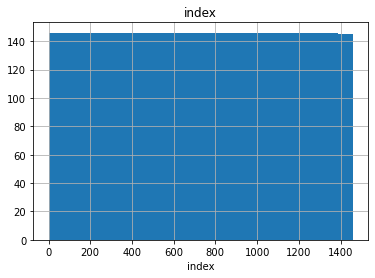

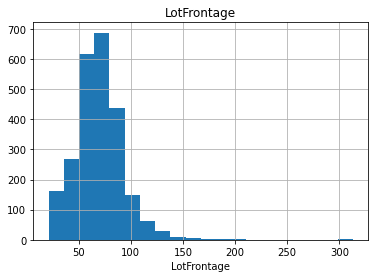

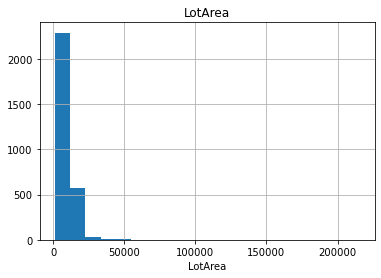

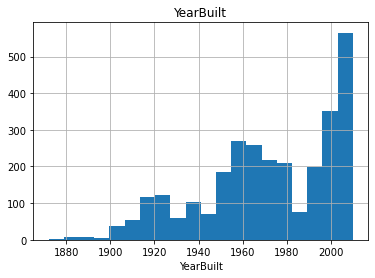

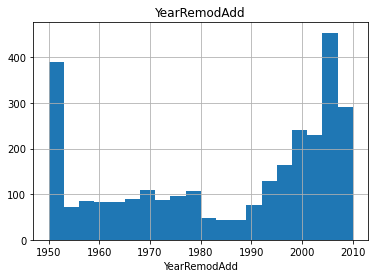

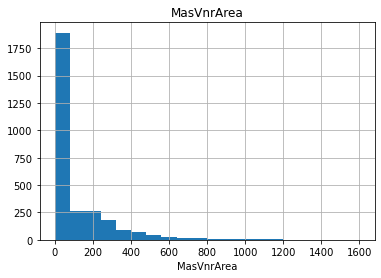

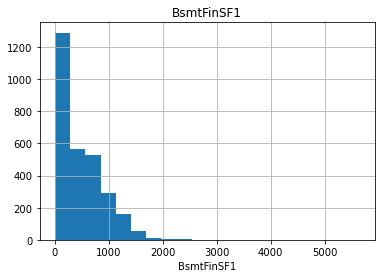

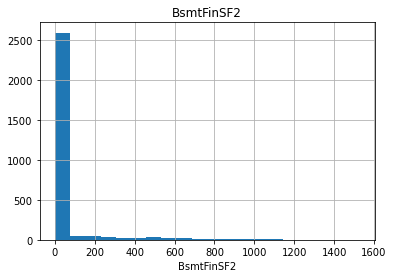

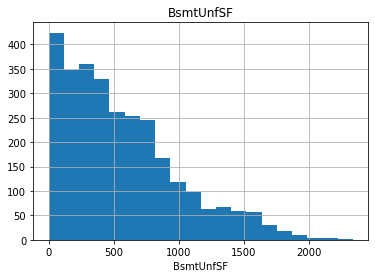

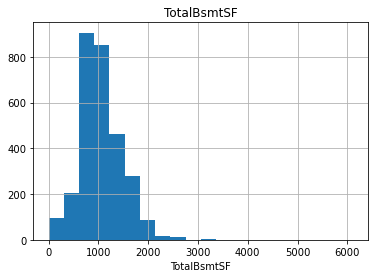

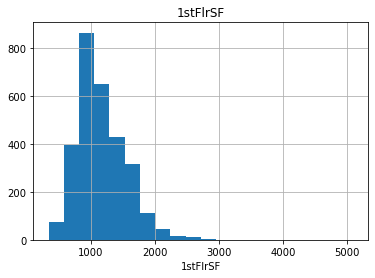

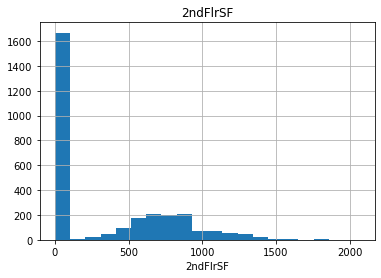

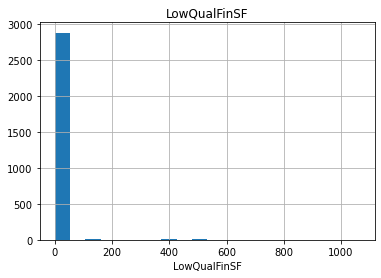

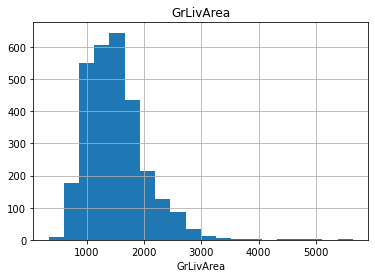

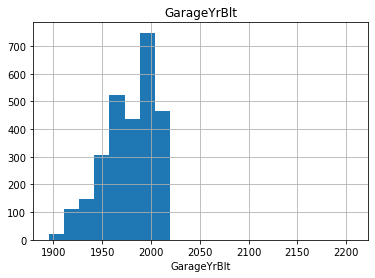

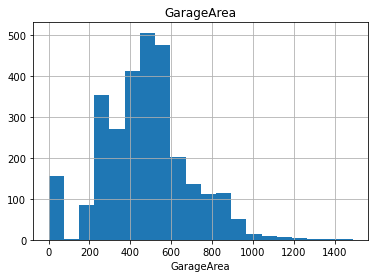

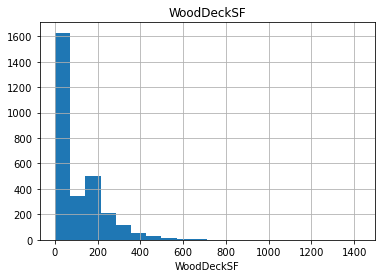

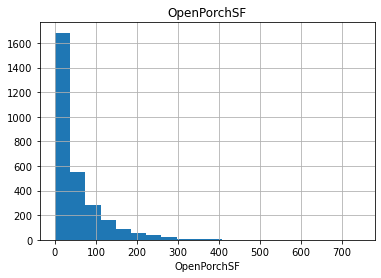

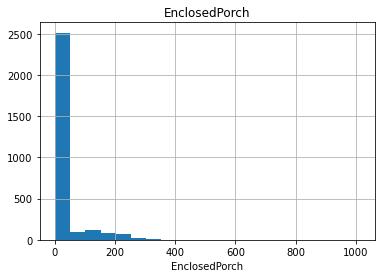

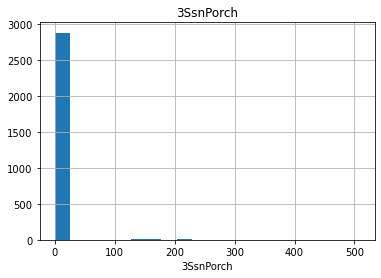

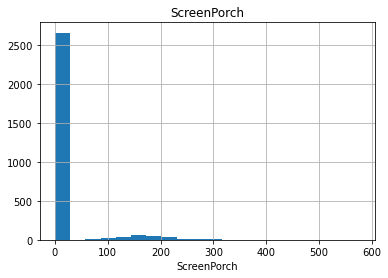

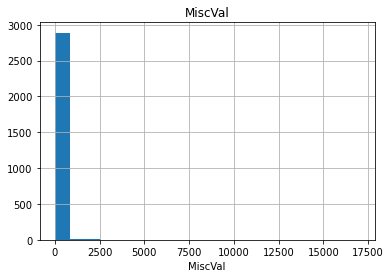

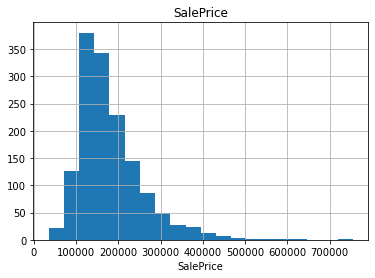

23 variables have been plotted!


In [24]:
hist_for_numeric_columns(df, numerical_columns)

# Step 5- Correlation Analysis

In [25]:
low_corr_list, up_corr_list = find_correlation(df, numerical_columns, "SalePrice")
print("\nHighly correlated list : ", len(up_corr_list))
for up in up_corr_list:
    print(up)
print("\nLow correlated list : ", len(low_corr_list))
for low in low_corr_list:
    print(low)


Highly correlated list :  4
TotalBsmtSF : 0.6135805515591944
1stFlrSF : 0.6058521846919166
GrLivArea : 0.7086244776126511
GarageArea : 0.6234314389183598

Low correlated list :  18
index : -0.021916719443431112
LotFrontage : 0.35179909657067854
LotArea : 0.2638433538714063
YearBuilt : 0.5228973328794967
YearRemodAdd : 0.5071009671113867
MasVnrArea : 0.4774930470957107
BsmtFinSF1 : 0.38641980624215627
BsmtFinSF2 : -0.011378121450215216
BsmtUnfSF : 0.214479105546969
2ndFlrSF : 0.31933380283206614
LowQualFinSF : -0.02560613000068015
GarageYrBlt : 0.48636167748786213
WoodDeckSF : 0.32441344456813076
OpenPorchSF : 0.31585622711605577
EnclosedPorch : -0.12857795792595636
3SsnPorch : 0.04458366533574792
ScreenPorch : 0.11144657114291048
MiscVal : -0.02118957964030379



# Step 6 -Missing Value Analysis

In [26]:
miss_values = missing_values_table(df)

              n_miss   ratio
PoolQC          2909 99.6600
MiscFeature     2814 96.4000
Alley           2721 93.2200
Fence           2348 80.4400
SalePrice       1459 49.9800
FireplaceQu     1420 48.6500
LotFrontage      486 16.6500
GarageYrBlt      159  5.4500
GarageFinish     159  5.4500
GarageQual       159  5.4500
GarageCond       159  5.4500
GarageType       157  5.3800
BsmtCond          82  2.8100
BsmtExposure      82  2.8100
BsmtQual          81  2.7700
BsmtFinType2      80  2.7400
BsmtFinType1      79  2.7100
MasVnrType        24  0.8200
MasVnrArea        23  0.7900
MSZoning           4  0.1400
BsmtFullBath       2  0.0700
BsmtHalfBath       2  0.0700
Functional         2  0.0700
Utilities          2  0.0700
BsmtFinSF2         1  0.0300
BsmtUnfSF          1  0.0300
BsmtFinSF1         1  0.0300
TotalBsmtSF        1  0.0300
SaleType           1  0.0300
KitchenQual        1  0.0300
Exterior2nd        1  0.0300
Exterior1st        1  0.0300
GarageCars         1  0.0300
GarageArea    

# Step 7 - Filling in missing values

In [27]:
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])

df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

df["Functional"] = df["Functional"].fillna("Typ")

fill_none_col = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
                 "BsmtQual","GarageCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType","MSSubClass"]
for col in fill_none_col:
    df[col] = df[col].fillna("None")

fill_0_col = ["GarageYrBlt","GarageArea","GarageCars","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","MasVnrArea"]
for col in fill_0_col:
    df[col] = df[col].fillna(0)

fill_mod_col = ["Electrical","KitchenQual","Exterior2nd","SaleType"]
for col in fill_mod_col:
    df[col] = df[col].fillna(df[col].mode()[0])

In [28]:
#Checking missing values
new_miss_values = missing_values_table(df)

           n_miss   ratio
SalePrice    1459 49.9800
Utilities       2  0.0700


# Step 8- Rare Analysis

In [29]:
rare_analyser(df, categorical_columns, "SalePrice", 0.02);

MSSubClass  :  16
     COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
20    1079 0.3696  185224.8116    159250.0000
30     139 0.0476   95829.7246     99900.0000
40       6 0.0021  156125.0000    142500.0000
45      18 0.0062  108591.6667    107500.0000
50     287 0.0983  143302.9722    132000.0000
60     575 0.1970  239948.5017    215200.0000
70     128 0.0439  166772.4167    156000.0000
75      23 0.0079  192437.5000    163500.0000
80     118 0.0404  169736.5517    166500.0000
85      48 0.0164  147810.0000    140750.0000
90     109 0.0373  133541.0769    135980.0000
120    182 0.0624  200779.0805    192000.0000
150      1 0.0003          nan            nan
160    128 0.0439  138647.3810    146000.0000
180     17 0.0058  102300.0000     88500.0000
190     61 0.0209  129613.3333    128250.0000


MSZoning  :  5
         COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
C (all)     25 0.0086   74528.0000     74700.0000
FV         139 0.0476  214014.0615    205950.0000
RH          26 0.0089  131558.375

There is only one class in these variables 96% and above so these don't have information for us.

In [30]:
first_drop_list = ["Street",'LotFrontage','GarageYrBlt', "Utilities", "Condition2", "RoofMatl", "PoolQC", "MiscFeature","KitchenAbvGr"]
for col in first_drop_list:
    df.drop(col, axis=1, inplace=True)


new_categorical_columns, new_numerical_columns = get_categorical_and_numeric_columns(df, "Id")
print("\nCategorical columns : ", new_categorical_columns,
      "\n\nNumeric Columns : ", new_numerical_columns)


Categorical columns :  ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolArea', 'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'] 

Numeric Columns :  ['index', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorc

In [31]:
rare_analyser(df, new_categorical_columns, "SalePrice", 0.02)

MSSubClass  :  16
     COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
20    1079 0.3696  185224.8116    159250.0000
30     139 0.0476   95829.7246     99900.0000
40       6 0.0021  156125.0000    142500.0000
45      18 0.0062  108591.6667    107500.0000
50     287 0.0983  143302.9722    132000.0000
60     575 0.1970  239948.5017    215200.0000
70     128 0.0439  166772.4167    156000.0000
75      23 0.0079  192437.5000    163500.0000
80     118 0.0404  169736.5517    166500.0000
85      48 0.0164  147810.0000    140750.0000
90     109 0.0373  133541.0769    135980.0000
120    182 0.0624  200779.0805    192000.0000
150      1 0.0003          nan            nan
160    128 0.0439  138647.3810    146000.0000
180     17 0.0058  102300.0000     88500.0000
190     61 0.0209  129613.3333    128250.0000


MSZoning  :  5
         COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
C (all)     25 0.0086   74528.0000     74700.0000
FV         139 0.0476  214014.0615    205950.0000
RH          26 0.0089  131558.375

In [32]:
rare_labels = ["TA", "Fa","Gd"]
df["BsmtQual"] = np.where(df["BsmtQual"].isin(rare_labels),"TF",df["BsmtQual"])
rare_labels = ["Gd", "TA"]
df["BsmtCond"] = np.where(df["BsmtCond"].isin(rare_labels),"GT",df["BsmtCond"])
df.BsmtExposure.replace(['Av','Gd','Mn','No'], [1,1,1, 0], inplace=True)
rare_labels = ["ALQ", "BLQ","LwQ","Rec","Unf"]
df["BsmtFinType1"] = np.where(df["BsmtFinType1"].isin(rare_labels),"Rare",df["BsmtFinType1"])
rare_labels = ["LwQ","Rec"]
df["BsmtFinType2"] = np.where(df["BsmtFinType2"].isin(rare_labels),"Rare",df["BsmtFinType2"])
rare_labels = ["ALQ", "GLQ","Unf"]
df["BsmtFinType2"] = np.where(df["BsmtFinType2"].isin(rare_labels),"R",df["BsmtFinType2"])
rare_labels = ["Unf", "RFn"]
df["GarageFinish"] = np.where(df["GarageFinish"].isin(rare_labels),"Urf",df["GarageFinish"])
rare_labels = ["Fa", "Po"]
df["GarageQual"] = np.where(df["GarageQual"].isin(rare_labels),"R",df["GarageQual"])
rare_labels = ["Gd", "Ex"]
df["GarageQual"] = np.where(df["GarageQual"].isin(rare_labels),"ge",df["GarageQual"])
rare_labels = ["Attchd", "BuiltIn"]
df["GarageType"] = np.where(df["GarageType"].isin(rare_labels),"AB",df["GarageType"])
rare_labels = ["CarPort", "Detchd"]
df["GarageType"] = np.where(df["GarageType"].isin(rare_labels),"cd",df["GarageType"])
rare_labels = [3,4]
df["GarageCars"] = np.where(df["GarageCars"].isin(rare_labels),3,df["GarageCars"])
rare_labels = [1,2]
df["GarageCars"] = np.where(df["GarageCars"].isin(rare_labels),1,df["GarageCars"])
rare_labels = ["Ex", "TA","Gd"]
df["ExterCond"] = np.where(df["ExterCond"].isin(rare_labels),"EGT",df["ExterCond"])
rare_labels = ["Fa","Po"]
df["ExterCond"] = np.where(df["ExterCond"].isin(rare_labels),"FP",df["ExterCond"])
rare_labels = ["Floor","Wall","Grav"]
df["Heating"] = np.where(df["Heating"].isin(rare_labels),"FWG",df["Heating"])
rare_labels = ["Lvl","Bnk"]
df["LandContour"] = np.where(df["LandContour"].isin(rare_labels),"LB",df["LandContour"])
rare_labels = ["CulDSac","FR3"]
df["LotConfig"] = np.where(df["LotConfig"].isin(rare_labels),"CF",df["LotConfig"])
rare_labels = ["Corner","FR2","Inside"]
df["LotConfig"] = np.where(df["LotConfig"].isin(rare_labels),"CF2I",df["LotConfig"])


# MSZoning 
df.loc[df["MSZoning"] == "RH", ["MSZoning"]] = "RM"

# LotShape 
df.loc[df["LotShape"] == "IR3", ["LotShape"]] = "IR1"
df.loc[df["LotShape"] == "IR2", ["LotShape"]] = "IR1"



# LandSlope 
df.loc[df["LandSlope"] == "Sev", ["LandSlope"]] = "Mod"

# Condition1 
df.loc[df["Condition1"] == "PosA", ["Condition1"]] = "NEW_PosAN"
df.loc[df["Condition1"] == "PosN", ["Condition1"]] = "NEW_PosAN"

df.loc[df["Condition1"] == "RRNe", ["Condition1"]] = "NEW_RRANe"
df.loc[df["Condition1"] == "RRAe", ["Condition1"]] = "NEW_RRANe"

df.loc[df["Condition1"] == "RRAn", ["Condition1"]] = "NEW_RRANn"
df.loc[df["Condition1"] == "RRNn", ["Condition1"]] = "NEW_RRANn"

# HouseStyle 
df.loc[df["HouseStyle"] == "2.5Fin", ["HouseStyle"]] = "2Story"

# OverallQual 
df.loc[df["OverallQual"] == 10, ["OverallQual"]] = 8
df.loc[df["OverallQual"] == 9, ["OverallQual"]] = 8

df.loc[df["OverallQual"] == 1, ["OverallQual"]] = 4
df.loc[df["OverallQual"] == 2, ["OverallQual"]] = 4
df.loc[df["OverallQual"] == 3, ["OverallQual"]] = 4


# RoofStyle 
df.loc[df["RoofStyle"] == "Mansard", ["RoofStyle"]] = "Hip"
df.loc[df["RoofStyle"] == "Flat", ["RoofStyle"]] = "Hip"
df.loc[df["RoofStyle"] == "Gambrel", ["RoofStyle"]] = "Gable"

# Exterior1st 
df.loc[df["Exterior1st"] == "WdShing", ["Exterior1st"]] = "Wd Sdng"

df = df[~(df["Exterior1st"] == "AsphShn")]
df = df[~(df["Exterior1st"] == "CBlock")]
df = df[~(df["Exterior1st"] == "ImStucc")]
df = df[~(df["Exterior1st"] == "Stone")]
df = df[~(df["Exterior1st"] == "BrkComm")]

# Exterior2nd 

df.loc[df["Exterior2nd"] == "Wd Shng", ["Exterior2nd"]] = "Wd Sdng"

df = df[~(df["Exterior2nd"] == "AsphShn")]
df = df[~(df["Exterior2nd"] == "CBlock")]
df = df[~(df["Exterior2nd"] == "ImStucc")]
df = df[~(df["Exterior2nd"] == "Stone")]
df = df[~(df["Exterior2nd"] == "BrkComm")]

# MasVnrType 
df.loc[df["MasVnrType"] == "BrkCmn", ["MasVnrType"]] = "None"

# ExterQual 
df.loc[df["ExterQual"] == "Fa", ["ExterQual"]] = "TA"


# Foundation 
df.loc[df["Foundation"] == "Stone", ["Foundation"]] = "CBlock"
df.loc[df["Foundation"] == "Slab", ["Foundation"]] = "CBlock"


# HeatingQC 
# df.loc[df["HeatingQC"] == "Po", ["HeatingQC"]] = "TA"
df.loc[df["HeatingQC"] == "Fa", ["HeatingQC"]] = "TA"
df = df[~(df["HeatingQC"] == "Po")]


# BedroomAbvGr 

df.loc[df["BedroomAbvGr"] == 8, ["BedroomAbvGr"]] = 4
df.loc[df["BedroomAbvGr"] == 5, ["BedroomAbvGr"]] = 4
df.loc[df["BedroomAbvGr"] == 6, ["BedroomAbvGr"]] = 4
df.loc[df["BedroomAbvGr"] == 2, ["BedroomAbvGr"]] = 1

# TotRmsAbvGrd 
df.loc[df["TotRmsAbvGrd"] == 11, ["TotRmsAbvGrd"]] = 10
df.loc[df["TotRmsAbvGrd"] == 14, ["TotRmsAbvGrd"]] = 8
df.loc[df["TotRmsAbvGrd"] == 3, ["TotRmsAbvGrd"]] = 4

# TotRmsAbvGrd 
df = df[~(df["TotRmsAbvGrd"] == 0)]
df.loc[df["TotRmsAbvGrd"] == 11, ["TotRmsAbvGrd"]] = 10
df.loc[df["TotRmsAbvGrd"] == 14, ["TotRmsAbvGrd"]] = 8
df.loc[df["TotRmsAbvGrd"] == 12, ["TotRmsAbvGrd"]] = 8

# Functional 
df.loc[df["Functional"] == "Maj1", ["Functional"]] = "NEW_Others"
df.loc[df["Functional"] == "Maj2", ["Functional"]] = "NEW_Others"
df.loc[df["Functional"] == "Min1", ["Functional"]] = "NEW_Others"
df.loc[df["Functional"] == "Min2", ["Functional"]] = "NEW_Others"
df.loc[df["Functional"] == "Mod", ["Functional"]] = "NEW_Others"
df = df[~(df["Functional"] == "Sev")]



# FireplaceQu k
df.loc[df["FireplaceQu"] == "Po", ["FireplaceQu"]] = "No"
df.loc[df["FireplaceQu"] == "Fa", ["FireplaceQu"]] = "TA"
df.loc[df["FireplaceQu"] == "Ex", ["FireplaceQu"]] = "Gd"


# GarageCond 
df.loc[df["GarageCond"] == "Po", ["GarageCond"]] = "No"
df.loc[df["GarageCond"] == "Fa", ["GarageCond"]] = "No"
df.loc[df["GarageCond"] == "Ex", ["GarageCond"]] = "TA"
df.loc[df["GarageCond"] == "Gd", ["GarageCond"]] = "TA"

# Fence - 
df.loc[df["Fence"] == "GdPrv", ["Fence"]] = "NEW_Fence"
df.loc[df["Fence"] == "GdWo", ["Fence"]] = "NEW_Fence"
df.loc[df["Fence"] == "MnPrv", ["Fence"]] = "NEW_Fence"
df.loc[df["Fence"] == "MnWw", ["Fence"]] = "NEW_Fence"

# SaleType 
df.loc[df["SaleType"] == "ConLI", ["SaleType"]] = "Con"
df.loc[df["SaleType"] == "ConLw", ["SaleType"]] = "Con"
df.loc[df["SaleType"] == "ConLD", ["SaleType"]] = "Con"
df.loc[df["SaleType"] == "Oth", ["SaleType"]] = "Con"

df.loc[df["SaleType"] == "CWD", ["SaleType"]] = "WD"

# SaleCondition 
df.loc[df["SaleCondition"] == "AdjLand", ["SaleCondition"]] = "Normal"

df.loc[df["SaleCondition"] == "Alloca", ["SaleCondition"]] = "Abnorml"
df.loc[df["SaleCondition"] == "Family", ["SaleCondition"]] = "Normal"

In [33]:
rare_analyser(df, new_categorical_columns, "SalePrice", 0.5)
last_miss = missing_values_table(df)
df.head()

MSSubClass  :  16
     COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
20    1065 0.3700  185044.3548    159000.0000
30     139 0.0483   95829.7246     99900.0000
40       6 0.0021  156125.0000    142500.0000
45      17 0.0059  110554.5455    109500.0000
50     282 0.0980  143335.4085    132000.0000
60     568 0.1974  238490.1763    215200.0000
70     127 0.0441  166772.4167    156000.0000
75      23 0.0080  192437.5000    163500.0000
80     116 0.0403  170995.0000    168000.0000
85      48 0.0167  147810.0000    140750.0000
90     102 0.0354  135950.7500    136702.5000
120    180 0.0625  201030.0000    192250.0000
150      1 0.0003          nan            nan
160    127 0.0441  139464.2742    146500.0000
180     17 0.0059  102300.0000     88500.0000
190     60 0.0208  129613.3333    128250.0000


MSZoning  :  4
         COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
C (all)     25 0.0087   74528.0000     74700.0000
FV         139 0.0483  214014.0615    205950.0000
RL        2233 0.7759  190917.559

,index,Id,MSSubClass,MSZoning,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1461,20,RM,11622,None,Reg,LB,CF2I,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0000,TA,EGT,CBlock,TF,GT,0,Rare,468.0000,Rare,144.0000,270.0000,882.0000,GasA,TA,Y,SBrkr,896,0,0,896,0.0000,0.0000,1,0,1,TA,5,Typ,0,None,AB,Urf,1.0000,730.0000,TA,TA,Y,140,0,0,0,120,0,NEW_Fence,0,6,2010,WD,Normal,nan
1,1,1462,20,RL,14267,None,IR1,LB,CF2I,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0000,TA,EGT,CBlock,TF,GT,0,Rare,923.0000,R,0.0000,406.0000,1329.0000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0000,0.0000,1,1,3,Gd,6,Typ,0,None,AB,Urf,1.0000,312.0000,TA,TA,Y,393,36,0,0,0,0,None,12500,6,2010,WD,Normal,nan
2,2,1463,60,RL,13830,None,IR1,LB,CF2I,Gtl,Gilbert,Norm,1Fam,2Story,5,5,1997,1998,Gable,VinylSd,VinylSd,None,0.0000,TA,EGT,PConc,TF,GT,0,GLQ,791.0000,R,0.0000,137.0000,928.0000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0000,0.0000,2,1,3,TA,6,Typ,1,TA,AB,Fin,1.0000,482.0000,TA,TA,Y,212,34,0,0,0,0,NEW_Fence,0,3,2010,WD,Normal,nan
3,3,1464,60,RL,9978,None,IR1,LB,CF2I,Gtl,Gilbert,Norm,1Fam,2Story,6,6,1998,1998,Gable,VinylSd,VinylSd,BrkFace,20.0000,TA,EGT,PConc,TF,GT,0,GLQ,602.0000,R,0.0000,324.0000,926.0000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0000,0.0000,2,1,3,Gd,7,Typ,1,Gd,AB,Fin,1.0000,470.0000,TA,TA,Y,360,36,0,0,0,0,None,0,6,2010,WD,Normal,nan
4,4,1465,120,RL,5005,None,IR1,HLS,CF2I,Gtl,StoneBr,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,HdBoard,HdBoard,None,0.0000,Gd,EGT,PConc,TF,GT,0,Rare,263.0000,R,0.0000,1017.0000,1280.0000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0000,0.0000,2,0,1,Gd,5,Typ,0,None,AB,Urf,1.0000,506.0000,TA,TA,Y,0,82,0,0,144,0,None,0,1,2010,WD,Normal,nan


# Step 9- Feature Engineering

In [34]:
df['New_TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df["NEW_TotalBathRoom"] = df["FullBath"] + df["HalfBath"]*0.5 + df["BsmtFullBath"] + df["BsmtHalfBath"]*0.5

df["NEW_TotalFeet"]= df["GrLivArea"] + df["TotalBsmtSF"]

df["New_Relation"] = (df["OpenPorchSF"]+df["EnclosedPorch"] + df["ScreenPorch"] + df["WoodDeckSF"]) / (df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'])

In [35]:
df_temp = df

df.head()

df, new_cols_ohe = one_hot_encoder(df, new_categorical_columns)

outlier_columns = has_outliers(df, new_numerical_columns)

replace_with_thresholds(df, new_numerical_columns)

df.head()


LotArea  :  24  aykırı gözlem.
MasVnrArea  :  6  aykırı gözlem.
BsmtFinSF1  :  2  aykırı gözlem.
BsmtFinSF2  :  13  aykırı gözlem.
TotalBsmtSF  :  2  aykırı gözlem.
1stFlrSF  :  3  aykırı gözlem.
LowQualFinSF  :  40  aykırı gözlem.
GrLivArea  :  2  aykırı gözlem.
WoodDeckSF  :  3  aykırı gözlem.
OpenPorchSF  :  6  aykırı gözlem.
EnclosedPorch  :  5  aykırı gözlem.
3SsnPorch  :  37  aykırı gözlem.
ScreenPorch  :  5  aykırı gözlem.
MiscVal  :  102  aykırı gözlem.
SalePrice  :  1  aykırı gözlem.


,index,Id,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,New_TotalSF,NEW_TotalBathRoom,NEW_TotalFeet,New_Relation,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Pave,LotShape_Reg,LandContour_LB,LandContour_Low,LotConfig_CF2I,LandSlope_Mod,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_NEW_PosAN,Condition1_NEW_RRANe,Condition1_NEW_RRANn,Condition1_Norm,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Hip,RoofStyle_Shed,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_None,MasVnrType_Stone,ExterQual_Gd,ExterQual_TA,ExterCond_FP,Foundation_CBlock,Foundation_PConc,Foundation_Wood,BsmtQual_None,BsmtQual_TF,BsmtCond_GT,BsmtCond_None,BsmtCond_Po,BsmtExposure_1,BsmtExposure_None,BsmtFinType1_None,BsmtFinType1_Rare,BsmtFinType2_None,BsmtFinType2_R,BsmtFinType2_Rare,Heating_GasA,Heating_GasW,Heating_OthW,HeatingQC_Gd,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtFullBath_3.0,BsmtHalfBath_1.0,BsmtHalfBath_2.0,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_3,BedroomAbvGr_4,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_13,TotRmsAbvGrd_15,Functional_Typ,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,FireplaceQu_No,FireplaceQu_None,FireplaceQu_TA,GarageType_AB,GarageType_Basment,GarageType_None,GarageType_cd,GarageFinish_None,GarageFinish_Urf,GarageCars_1.0,GarageCars_3.0,GarageCars_5.0,GarageQual_R,GarageQual_TA,GarageQual_ge,GarageCond_None,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolArea_144,PoolArea_228,PoolArea_368,PoolArea_444,PoolArea_480,PoolArea_512,PoolArea_519,PoolArea_561,PoolArea_576,PoolArea_648,PoolArea_738,PoolArea_800,Fence_None,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_Con,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial
0,0.0000,1461,11622.0000,1961.0000,1961.0000,0.0000,468.0000,144.0000,270.0000,882.0000,896.0000,0.0000,0.0000,896.0000,730.0000,140.0000,0.0000,0.0000,0.0000,120.0000,0.0000,nan,1778.0000,1.0000,1778.0000,0.1462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,

In [36]:
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) < 20]
cols_need_scale = [col for col in df.columns if col not in new_cols_ohe
                   and col not in "Id"
                   and col not in "SalePrice"
                   and col not in like_num]

for col in cols_need_scale:
    df[col] = robust_scaler(df[col])

In [37]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

missing_values_table(train_df)
missing_values_table(test_df)

test_df.isnull().sum()

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
           n_miss    ratio
SalePrice    1442 100.0000


index                    0
Id                       0
LotArea                  0
YearBuilt                0
YearRemodAdd             0
                        ..
SaleType_Con             0
SaleType_New             0
SaleType_WD              0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 235, dtype: int64

**Save the final version of the data frames as a pickle**

In [38]:
train_df.to_pickle(".//train.pkl")
test_df.to_pickle("./test.pkl")

In [39]:
drop_list = ["index", "Id"]
train_df.drop(drop_list, axis=1, inplace=True)

X = train_df.drop('SalePrice', axis=1) # bagımsız degıskenler
y = np.ravel(train_df[["SalePrice"]]) # bagımlı degısken

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=46)

y_train = np.ravel(y_train)

models = [('LinearRegression', LinearRegression()),
          ('Ridge', Ridge()),
          ('Lasso', Lasso()),
          ('ElasticNet', ElasticNet())]

results = []
names = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append(result)
    names.append(name)

    msg = "%s: %f" % (name, result)
    print(msg)

LinearRegression: 415021072416956.937500
Ridge: 24261.662492
Lasso: 24659.293988
ElasticNet: 30019.371314
